<a href="https://colab.research.google.com/github/konradish/MachineLearning/blob/main/Image_Enhancing_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN TF Keras
# Keeping it simple

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, add, Concatenate, Conv2D, Conv2DTranspose, Activation, MaxPooling2D, Dropout, UpSampling2D, BatchNormalization, AveragePooling2D, InputLayer
from tensorflow.keras.models import Sequential

img_w=300
img_h=300
img_shape=(img_h,img_w,3)
img_w_h = (img_w, img_h)


In [19]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [20]:
import glob, random, cv2, numpy as np
from PIL import Image, ImageEnhance, ImageFilter
from io import BytesIO

def degrade(img):
    img_down = cv2.resize(img, img_w_h)
    img_down_pil = Image.fromarray(img_down)


    # img_down_pil = ImageEnhance.Color(img_down_pil).enhance(0.0)
    # img_down_pil = ImageEnhance.Contrast(img_down_pil).enhance(0.5)
    # img_down_pil = ImageEnhance.Brightness(img_down_pil).enhance(0.8)
    
    out = BytesIO()
    img_down_pil.save(out, format="JPEG",quality=10)
    out.seek(0)
    img_down_pil = Image.open(out)
    
    train_X = np.array(img_down_pil) / 255.
    noise_factor=0.0
    train_X_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)  
    train_X_noisy = np.clip(train_X_noisy, 0., 1.)
    return train_X_noisy

def get_random_images(folder_name, batch_size):
    X = []
    X_down = []
    jpgs=glob.glob("%s/*.jpg" % folder_name) + glob.glob("%s/*.jpeg" % folder_name) +  glob.glob("%s/*.webp" % folder_name) + glob.glob("%s/*.jfif" % folder_name) + glob.glob("%s/*.png" % folder_name)
    random.shuffle(jpgs)
    for jpg in jpgs[:batch_size]:
        img=cv2.imread(jpg)
        img = cv2.resize(img, img_w_h)
        X.append( img / 255. )
        train_X_noisy = degrade(img)
        X_down.append(train_X_noisy)
    return X, X_down

def show_image(image):
    display_image = np.uint8(image*255.)
    display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(display_image)
    display(im_pil)
    
def show_images(images):
    for image in images:
        show_image(image)


In [21]:
def get_model(img_shape):
    return Sequential([
        InputLayer(img_shape),
        Conv2D(8, (3,3), padding = 'same', activation='relu', use_bias=False ),
        BatchNormalization(),
        Conv2D(16, (3,3), padding = 'same', activation='relu', use_bias=False ),
        BatchNormalization(),
        Conv2D(32, (3,3), padding = 'same', activation='relu', use_bias=False ),
        BatchNormalization(),
        Conv2D(64, (3,3), padding = 'same', activation='relu', use_bias=False ),
        BatchNormalization(),
        Conv2D(128, (3,3), padding = 'same', activation='relu', use_bias=False ),
        BatchNormalization(),
        Conv2D(128, (3,3), padding = 'same', activation='relu', use_bias=False ),
        BatchNormalization(),
        Conv2D(64, (3,3), padding = 'same', activation='relu', use_bias=False ),
        BatchNormalization(),
        Conv2D(32, (3,3), padding = 'same', activation='relu', use_bias=False ),
        BatchNormalization(),
        Conv2D(16, (3,3), padding = 'same', activation='relu', use_bias=False ),
        BatchNormalization(),
        Conv2D(8, (3,3), padding = 'same', activation='relu', use_bias=False ),
        BatchNormalization(),
        Conv2D(3, 3, padding = 'same')
    ])

In [28]:
import datetime
# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
model = get_model(img_shape)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.mse, metrics=['accuracy']
)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 300, 300, 8)       216       
                                                                 
 batch_normalization_20 (Bat  (None, 300, 300, 8)      32        
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 300, 300, 16)      1152      
                                                                 
 batch_normalization_21 (Bat  (None, 300, 300, 16)     64        
 chNormalization)                                                
                                                                 
 conv2d_24 (Conv2D)          (None, 300, 300, 32)      4608      
                                                                 
 batch_normalization_22 (Bat  (None, 300, 300, 32)    

In [23]:
def predict(img):
    reco = model.predict(np.array([img]))[0]
    reco = np.uint8(reco*255.)
    reco = cv2.cvtColor(reco, cv2.COLOR_BGR2RGB)
    reco = Image.fromarray(reco)
    return reco

def display_reco(img_path):
    s_img=cv2.imread(img_path)
    img_down = cv2.resize(s_img, img_w_h)
    train_X_noisy = degrade(img_down)
    display(predict(train_X_noisy))

In [24]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir+='/roses'

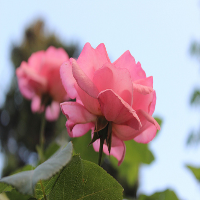

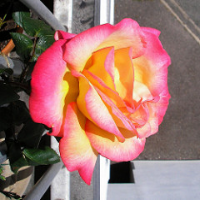

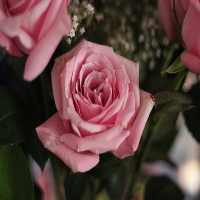

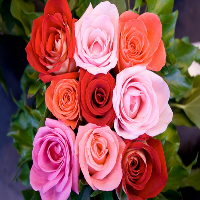

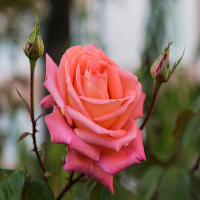

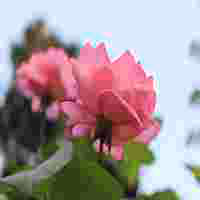

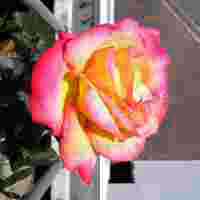

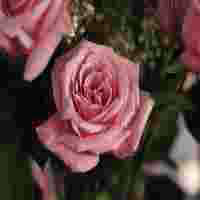

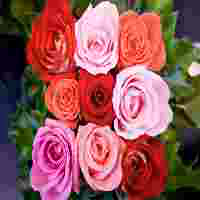

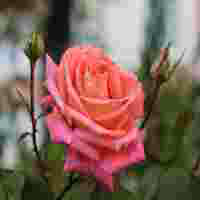

In [25]:
ups, downs = get_random_images(data_dir, 5)
show_images(ups[:5]+downs[:5])

# New Section

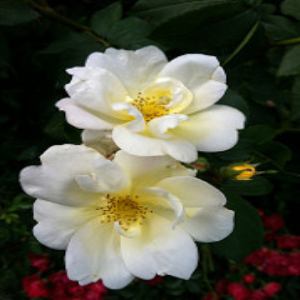

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0067 - accuracy: 0.7595 - val_loss: 0.0059 - val_accuracy: 0.7907
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0069 - accuracy: 0.7371 - val_loss: 0.0070 - val_accuracy: 0.8194
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0076 - accuracy: 0.7310 - val_loss: 0.0055 - val_accuracy: 0.8311
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0067 - accuracy: 0.7308 - val_loss: 0.0051 - val_accuracy: 0.8136
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0069 - accuracy: 0.7586 - val_loss: 0.0050 - val_accuracy: 0.8023


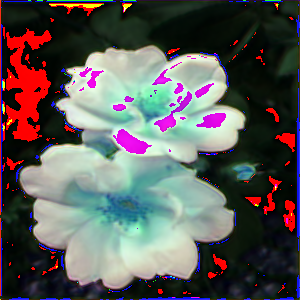

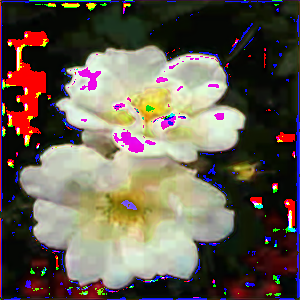

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0080 - accuracy: 0.7128 - val_loss: 0.0080 - val_accuracy: 0.7177
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0059 - accuracy: 0.7053 - val_loss: 0.0076 - val_accuracy: 0.7232
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0059 - accuracy: 0.7325 - val_loss: 0.0078 - val_accuracy: 0.7572
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0055 - accuracy: 0.7339 - val_loss: 0.0074 - val_accuracy: 0.7630
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0073 - accuracy: 0.7013 - val_loss: 0.0059 - val_accuracy: 0.7655


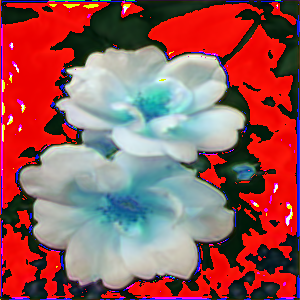

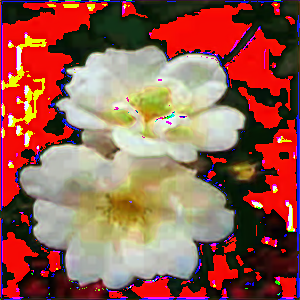

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0089 - accuracy: 0.7550 - val_loss: 0.0050 - val_accuracy: 0.7290
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0103 - accuracy: 0.7457 - val_loss: 0.0061 - val_accuracy: 0.7517
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0071 - accuracy: 0.7178 - val_loss: 0.0066 - val_accuracy: 0.6943
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0079 - accuracy: 0.7489 - val_loss: 0.0069 - val_accuracy: 0.7330
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0077 - accuracy: 0.7161 - val_loss: 0.0066 - val_accuracy: 0.7620


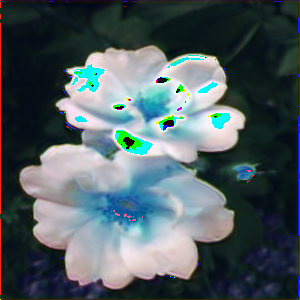

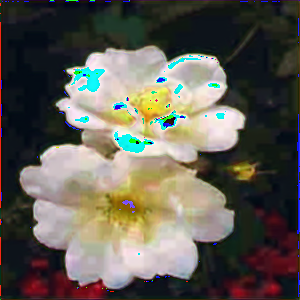

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0098 - accuracy: 0.7090 - val_loss: 0.0051 - val_accuracy: 0.7717
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0084 - accuracy: 0.6898 - val_loss: 0.0051 - val_accuracy: 0.7863
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0076 - accuracy: 0.7221 - val_loss: 0.0053 - val_accuracy: 0.7561
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0087 - accuracy: 0.7220 - val_loss: 0.0057 - val_accuracy: 0.7377
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0094 - accuracy: 0.6680 - val_loss: 0.0056 - val_accuracy: 0.7679


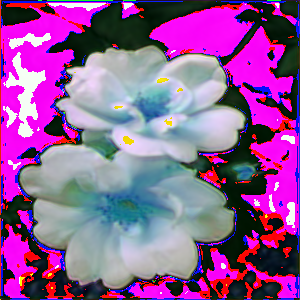

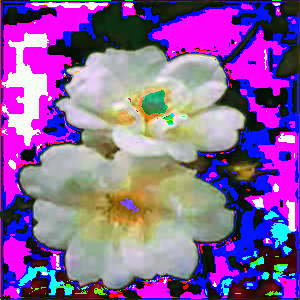

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0127 - accuracy: 0.7154 - val_loss: 0.0043 - val_accuracy: 0.7582
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0096 - accuracy: 0.7361 - val_loss: 0.0051 - val_accuracy: 0.7813
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0093 - accuracy: 0.7131 - val_loss: 0.0051 - val_accuracy: 0.6917
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0095 - accuracy: 0.7158 - val_loss: 0.0047 - val_accuracy: 0.7369
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0072 - accuracy: 0.7065 - val_loss: 0.0048 - val_accuracy: 0.6903


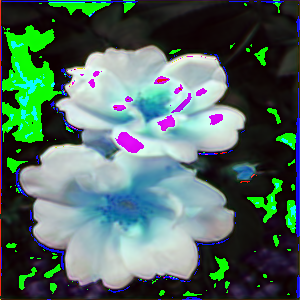

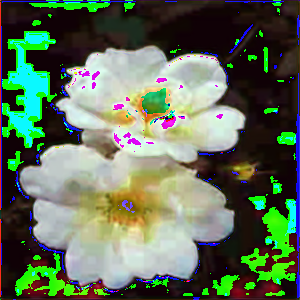

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0070 - accuracy: 0.7396 - val_loss: 0.0051 - val_accuracy: 0.7473
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0065 - accuracy: 0.7415 - val_loss: 0.0045 - val_accuracy: 0.7087
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0103 - accuracy: 0.7510 - val_loss: 0.0048 - val_accuracy: 0.6978
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0090 - accuracy: 0.7356 - val_loss: 0.0045 - val_accuracy: 0.7562
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0085 - accuracy: 0.7598 - val_loss: 0.0045 - val_accuracy: 0.6995


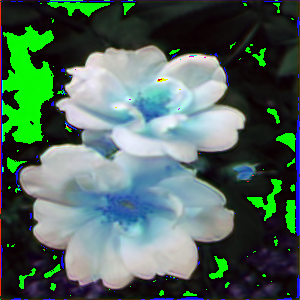

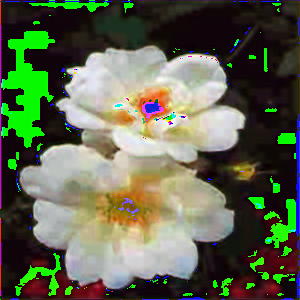

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0079 - accuracy: 0.7069 - val_loss: 0.0078 - val_accuracy: 0.7572
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0073 - accuracy: 0.7538 - val_loss: 0.0073 - val_accuracy: 0.7570
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0084 - accuracy: 0.6831 - val_loss: 0.0088 - val_accuracy: 0.7588
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0125 - accuracy: 0.7389 - val_loss: 0.0177 - val_accuracy: 0.7560
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0103 - accuracy: 0.7010 - val_loss: 0.0079 - val_accuracy: 0.7942


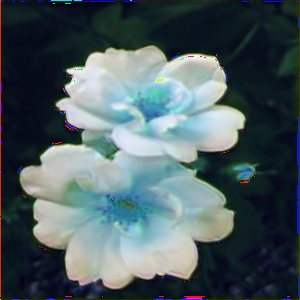

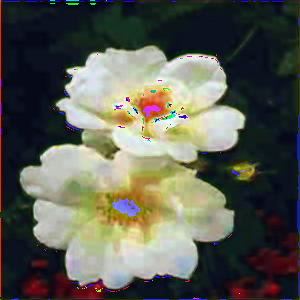

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0088 - accuracy: 0.6982 - val_loss: 0.0072 - val_accuracy: 0.7791
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0068 - accuracy: 0.7267 - val_loss: 0.0098 - val_accuracy: 0.7900
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0084 - accuracy: 0.7062 - val_loss: 0.0048 - val_accuracy: 0.7911
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0071 - accuracy: 0.7130 - val_loss: 0.0064 - val_accuracy: 0.7781
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0076 - accuracy: 0.7219 - val_loss: 0.0053 - val_accuracy: 0.7763


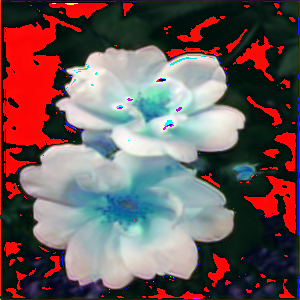

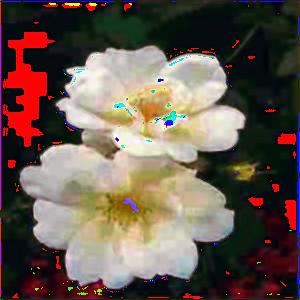

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0079 - accuracy: 0.7223 - val_loss: 0.0059 - val_accuracy: 0.7972
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0077 - accuracy: 0.6997 - val_loss: 0.0050 - val_accuracy: 0.8089
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0068 - accuracy: 0.7111 - val_loss: 0.0054 - val_accuracy: 0.7777
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0065 - accuracy: 0.7082 - val_loss: 0.0053 - val_accuracy: 0.7840
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0063 - accuracy: 0.7053 - val_loss: 0.0048 - val_accuracy: 0.7664


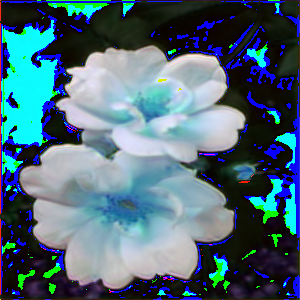

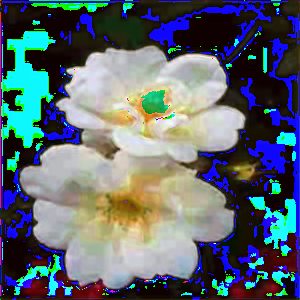

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0077 - accuracy: 0.7117 - val_loss: 0.0069 - val_accuracy: 0.7724
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0096 - accuracy: 0.6993 - val_loss: 0.0054 - val_accuracy: 0.7736
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0081 - accuracy: 0.7235 - val_loss: 0.0059 - val_accuracy: 0.7667
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0086 - accuracy: 0.6779 - val_loss: 0.0054 - val_accuracy: 0.7489
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0079 - accuracy: 0.6875 - val_loss: 0.0051 - val_accuracy: 0.7472


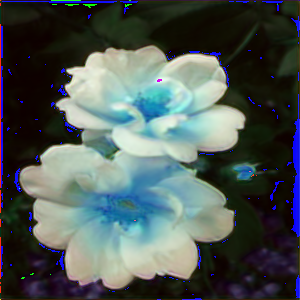

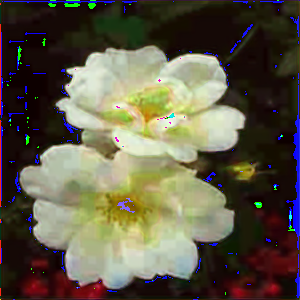

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0091 - accuracy: 0.7163 - val_loss: 0.0073 - val_accuracy: 0.7558
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0082 - accuracy: 0.7228 - val_loss: 0.0272 - val_accuracy: 0.7230
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0082 - accuracy: 0.7003 - val_loss: 0.0077 - val_accuracy: 0.6975
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0058 - accuracy: 0.7198 - val_loss: 0.0073 - val_accuracy: 0.7211
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0071 - accuracy: 0.7327 - val_loss: 0.0107 - val_accuracy: 0.7795


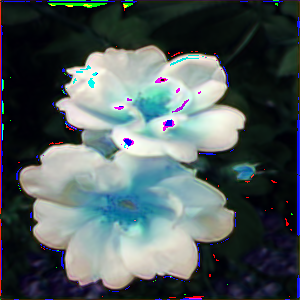

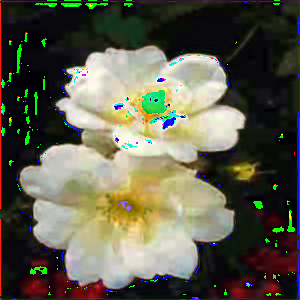

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0086 - accuracy: 0.7080 - val_loss: 0.0059 - val_accuracy: 0.7924
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0076 - accuracy: 0.7253 - val_loss: 0.0041 - val_accuracy: 0.7619
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0067 - accuracy: 0.7177 - val_loss: 0.0037 - val_accuracy: 0.8253
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0057 - accuracy: 0.7101 - val_loss: 0.0046 - val_accuracy: 0.8428
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0076 - accuracy: 0.7335 - val_loss: 0.0045 - val_accuracy: 0.7898


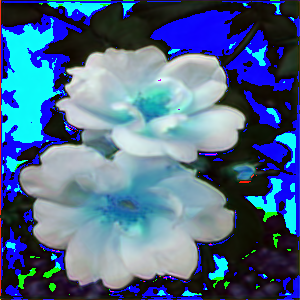

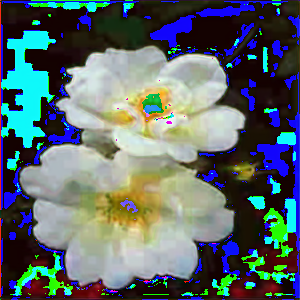

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0083 - accuracy: 0.6904 - val_loss: 0.0042 - val_accuracy: 0.8088
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0072 - accuracy: 0.6985 - val_loss: 0.0049 - val_accuracy: 0.8104
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0078 - accuracy: 0.7051 - val_loss: 0.0048 - val_accuracy: 0.8157
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0102 - accuracy: 0.7291 - val_loss: 0.0055 - val_accuracy: 0.7747
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0067 - accuracy: 0.6999 - val_loss: 0.0043 - val_accuracy: 0.8060


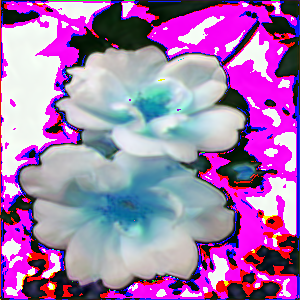

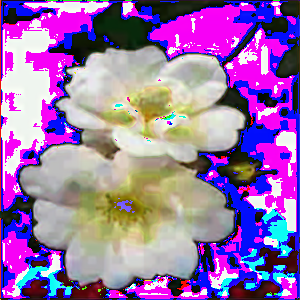

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0085 - accuracy: 0.6971 - val_loss: 0.0038 - val_accuracy: 0.7268
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0082 - accuracy: 0.7224 - val_loss: 0.0033 - val_accuracy: 0.7698
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0070 - accuracy: 0.6943 - val_loss: 0.0037 - val_accuracy: 0.7520
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0068 - accuracy: 0.7058 - val_loss: 0.0041 - val_accuracy: 0.8001
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0068 - accuracy: 0.6876 - val_loss: 0.0065 - val_accuracy: 0.8002


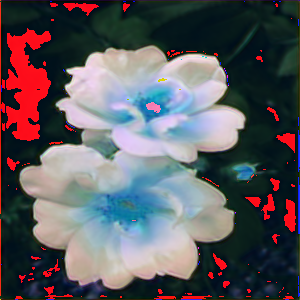

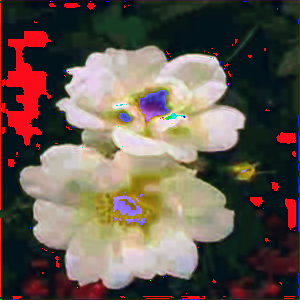

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0083 - accuracy: 0.7069 - val_loss: 0.0059 - val_accuracy: 0.5982
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0093 - accuracy: 0.7056 - val_loss: 0.0080 - val_accuracy: 0.7888
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0094 - accuracy: 0.6949 - val_loss: 0.0122 - val_accuracy: 0.5887
Epoch 4/5
8/8 [==============================] - 10s 1s/step - loss: 0.0092 - accuracy: 0.6972 - val_loss: 0.0082 - val_accuracy: 0.7960
Epoch 5/5
8/8 [==============================] - 10s 1s/step - loss: 0.0070 - accuracy: 0.7038 - val_loss: 0.0095 - val_accuracy: 0.6122


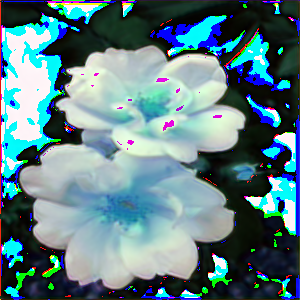

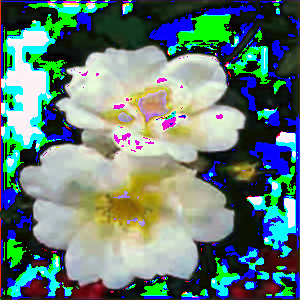

Epoch 1/5
8/8 [==============================] - 10s 1s/step - loss: 0.0111 - accuracy: 0.7317 - val_loss: 0.0085 - val_accuracy: 0.7392
Epoch 2/5
8/8 [==============================] - 10s 1s/step - loss: 0.0101 - accuracy: 0.7515 - val_loss: 0.0069 - val_accuracy: 0.7516
Epoch 3/5
8/8 [==============================] - 10s 1s/step - loss: 0.0059 - accuracy: 0.7264 - val_loss: 0.0052 - val_accuracy: 0.7714
Epoch 4/5
4/8 [==============>...............] - ETA: 4s - loss: 0.0119 - accuracy: 0.7049

In [ ]:
epochs = 5

s_img_path = data_dir+'/10090824183_d02c613f10_m.jpg'
s_img = Image.open(s_img_path)
s_img = np.array(s_img)
s_img = cv2.resize(s_img, img_w_h)
display(Image.fromarray(s_img))
s_img = np.array(s_img)/255.

for _ in range(10000):
    ups, downs = get_random_images(data_dir, 100)
    
    ups, downs = np.array(ups), np.array(downs)
    model.fit(
        x=downs, y=ups, epochs=epochs, verbose=1, batch_size=10, validation_split=.2
    )

    reco = model.predict(np.array([s_img]))[0]
    reco = np.uint8(reco*255.)
    reco = cv2.cvtColor(reco, cv2.COLOR_BGR2RGB)
    reco = Image.fromarray(reco)

    display(reco)
    display_reco(s_img_path)

In [31]:
model.save('/content/drive/MyDrive/Colab Notebooks/cnn_jpeg_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/cnn_jpeg_model/assets
